# Image Classification Project: 11 Types of Vietnamese Noodles

In this project, we build a classification model using a Residual Neural Network (ResNet). The model aims to discriminate pictures about 11 popular types of Vietnamese noodles. Those are bún chả-bún nem- bún thịt nướng, bún đậu, bún ngan, bún ốc, bún riêu, bún thang, miến lươn, phở bò, phở cuốn, phở gà, phở xào. Despite their popularity, these noodles look very similar that many foreigners found it hard to tell them apart. Motivated by this observation, the project aims to assist travellers in recognizing which kind of noodles they are eating. 

The dataset used in this project contains over 5,000 images collected via Google Images. The data was cleaned manually before training. The dataset is available on request, please send an email to minhdn24@gmail.com

In the following analysis, two ResNets of 34 and 50 layers are compared. We found that the 50-layer ResNet is better, achieving an accuracy of 78.4%. Using transfer learing, i.e., a pre-trained model with ImageNet dataset, we are able to train the network within a short amount of time, i.e., a few minutes. The project can be extended to a web-based application for online image classification.  

We first start by setting the libraries used in this notebook to be automatically reloaded if their source codes are changed during runtime. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We utilize the `fastai` library for fast model building and testing.

In [2]:
from fastai.vision import *

from fastai.metrics import error_rate

bs = 64

# Verifying Images 

In this section, we verify if the downloaded images can actually be opened. If there is an error, we simply delete the images.

In [3]:
path = Path('/home/ubuntu/Prj2')
classes = ['bun cha - bun nem - bun thit nuong','bun dau','bun ngan','bun oc','bun rieu','bun thang','mien luon','pho bo','pho cuon','pho ga','pho xao']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# Exploring Data

In this section, we look at a few samples of the data and prepare the data for training and testing using `ImageDataBunch` from the `fastai` library.

In [3]:
path = Path('/home/ubuntu/Prj2')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs=bs, num_workers=4).normalize(imagenet_stats)

We ensure that the data has eleven classes.

In [4]:
data.classes

['bun cha - bun nem - bun thit nuong',
 'bun dau',
 'bun ngan',
 'bun oc',
 'bun rieu',
 'bun thang',
 'mien luon',
 'pho bo',
 'pho cuon',
 'pho ga',
 'pho xao']

Let's look at some samples of the data.

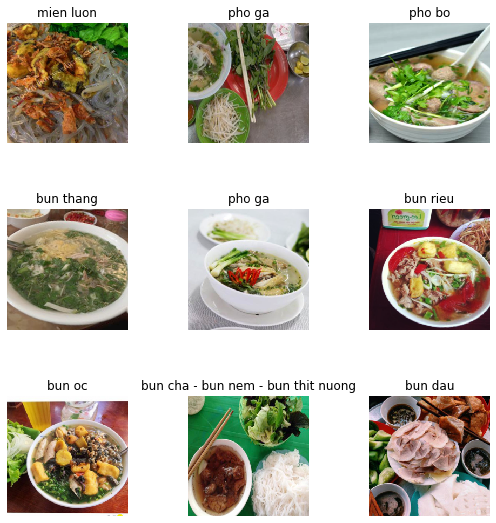

In [5]:
data.show_batch(rows=3, figsize=(7,8))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bun cha - bun nem - bun thit nuong',
  'bun dau',
  'bun ngan',
  'bun oc',
  'bun rieu',
  'bun thang',
  'mien luon',
  'pho bo',
  'pho cuon',
  'pho ga',
  'pho xao'],
 11,
 4089,
 1022)

We see that we have three classes in our dataset. 4,089 data points are used for tranining, and 1,022 photos are used for validating purpose.

# Training Resnet34

In this section, we train a ResNet with 34 layers. We use a pre-trained model of ResNet that has been trained with the ImageNet dataset. We use the error rate as the performance metric.

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [8]:
from fastai.callbacks import *

We first train the model using a few number of epochs. The best model is saved as `stage-1`.

epoch,train_loss,valid_loss,error_rate,time
0,2.029727,1.223528,0.397260,01:09
1,1.434075,1.042826,0.335616,00:42
2,1.144069,0.974589,0.307241,00:42
3,0.969768,0.963179,0.294521,00:41


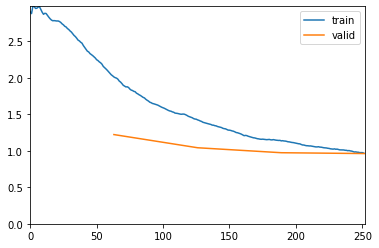

Better model found at epoch 0 with error_rate value: 0.39726027846336365.
Better model found at epoch 1 with error_rate value: 0.33561643958091736.
Better model found at epoch 2 with error_rate value: 0.30724069476127625.
Better model found at epoch 3 with error_rate value: 0.2945205569267273.


In [9]:
learn.fit_one_cycle(4, callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-1')])

We observe that the error rate is quite high, i.e., about 29.4%. Let's see if a ResNet50 will do better.

# Training ResNet50

In [12]:
learn_50 = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time
0,1.688323,1.181274,0.375734,01:12
1,1.213489,0.969040,0.312133,01:12
2,0.922086,0.862153,0.273973,01:13
3,0.772252,0.843942,0.273973,01:12


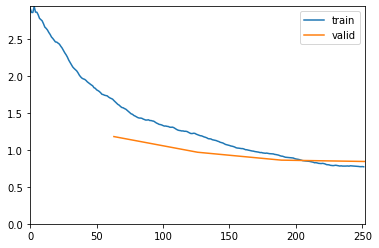

Better model found at epoch 0 with error_rate value: 0.3757338523864746.
Better model found at epoch 1 with error_rate value: 0.3121330738067627.
Better model found at epoch 2 with error_rate value: 0.27397260069847107.


In [13]:
learn_50.fit_one_cycle(4, callbacks=[ShowGraph(learn_50), SaveModelCallback(learn_50, monitor='error_rate', mode='min', name='stage-1-50')])

We see that the initial result of using a ResNet50 is a litle bit lower than ResNet34. We continue training by fine-tuning the model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


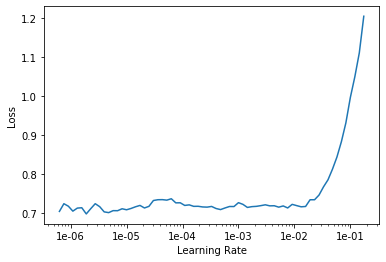

In [14]:
learn_50.lr_find()
learn_50.recorder.plot()

By inspection, we try the learning rate from 5e-6 to 5e-4.

epoch,train_loss,valid_loss,error_rate,time
0,0.698733,0.790408,0.260274,01:38
1,0.611603,0.717237,0.229941,01:35
2,0.457790,0.676305,0.215264,01:35
3,0.358180,0.677504,0.222114,01:35


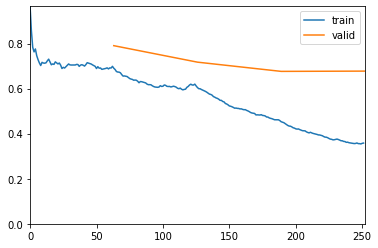

Better model found at epoch 0 with error_rate value: 0.2602739632129669.
Better model found at epoch 1 with error_rate value: 0.22994129359722137.
Better model found at epoch 2 with error_rate value: 0.2152641862630844.


In [15]:
learn_50.unfreeze()
learn_50.fit_one_cycle(4, max_lr=slice(5e-6,5e-4), callbacks=[ShowGraph(learn_50), SaveModelCallback(learn_50, monitor='error_rate', mode='min', name='stage-2-50')])

We further examine the learning rate and do some further training to see if we can improve the performance more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


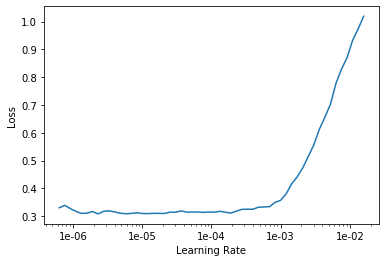

In [16]:
learn_50.lr_find()
learn_50.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.309896,0.679972,0.222114,01:35
1,0.317544,0.674949,0.221135,01:35
2,0.309932,0.675421,0.216243,01:36
3,0.300260,0.669420,0.216243,01:35


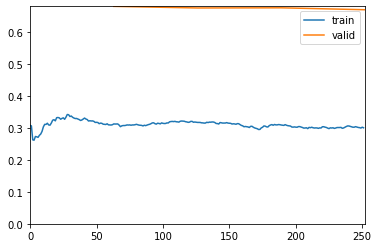

Better model found at epoch 0 with error_rate value: 0.2221135050058365.
Better model found at epoch 1 with error_rate value: 0.22113503515720367.
Better model found at epoch 2 with error_rate value: 0.21624265611171722.


In [17]:
learn_50.fit_one_cycle(4, max_lr=slice(1e-6,1e-5), callbacks=[ShowGraph(learn_50), SaveModelCallback(learn_50, monitor='error_rate', mode='min', name='stage-3-50')])

It seems that a better model is found in the previous step. We switch back to that model.

In [21]:
learn_50.load('stage-2-50');

We export the model for web application.

In [25]:
learn_50.export()

# Evaluation

In this section, we see the evaluation of the model by taking a look at the top losses plot and the confusion matrix, which demonstrate the mistakes that the model made.

In [22]:
interp = ClassificationInterpretation.from_learner(learn_50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

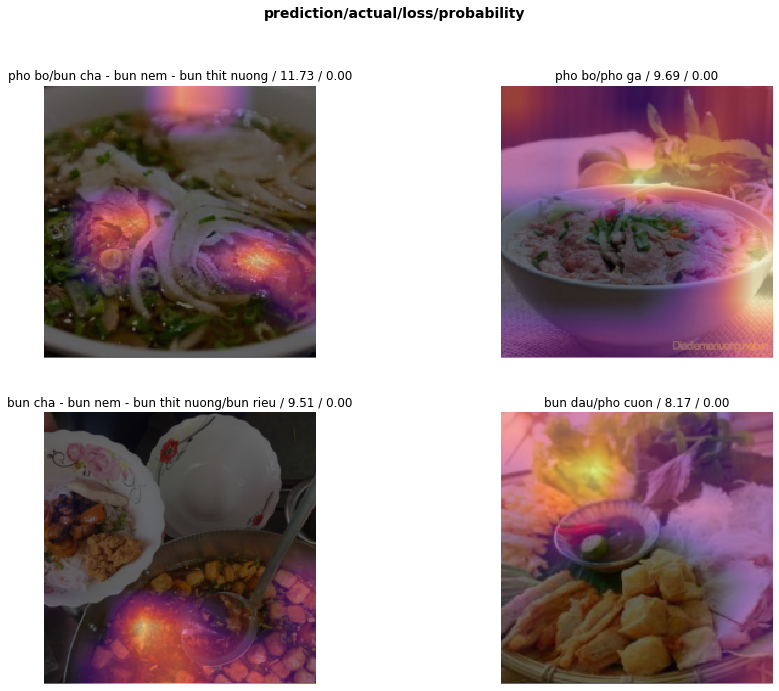

In [23]:
interp.plot_top_losses(4, figsize=(15,11))

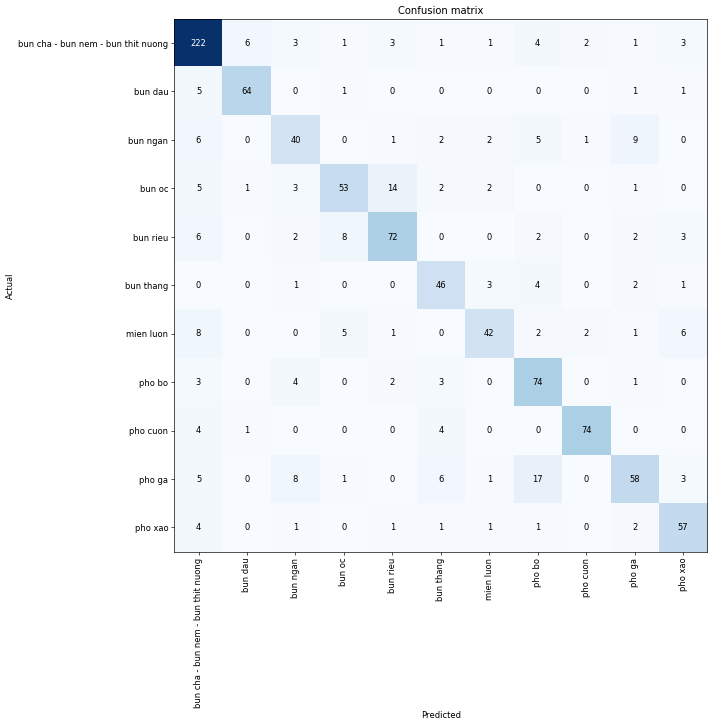

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We see that the cases when the model makes mistake are actually when the images are very similar. For example, images of phở gà and bún ngan. It is a good sight that the model does not make obvious mistake.


# Conclusion

In this project, we created a ResNet for discriminating 11 popular types of Vietnamese noodles. The best accuracy achieved is 78.4%. The model can be embedded in web applications to assist travellers in discriminating Vietnamese noodles.